# Analytic Vidya - Black Friday 

A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.
The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.
Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

## Data

| Variable                   | Definition                                          |
|----------------------------|-----------------------------------------------------|
| User_ID                    | User ID                                             |
| Product_ID                 | Product ID                                          |
| Gender                     | Sex of User                                         |
| Age                        | Age in bins                                         |
| Occupation                 | Occupation (Masked)                                 |
| City_Category              | Category of the City (A,B,C)                        |
| Stay_In_Current_City_Years | Number of years stay in current city                |
| Marital_Status             | Marital Status                                      |
| Product_Category_1         | Product Category (Masked)                           |
| Product_Category_2         | Product may belongs to other category also (Masked) |
| Product_Category_3         | Product may belongs to other category also (Masked) |
| Purchase                   | Purchase Amount (Target Variable)                   |

## Exploration

In [1]:
import pandas as pd

In [2]:
filename = './train_oSwQCTC/train.csv'
df = pd.read_csv(filename)

In [3]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
# missing data in Product_Category_2 and Product_Category_3
df.count()

User_ID                       550068
Product_ID                    550068
Gender                        550068
Age                           550068
Occupation                    550068
City_Category                 550068
Stay_In_Current_City_Years    550068
Marital_Status                550068
Product_Category_1            550068
Product_Category_2            376430
Product_Category_3            166821
Purchase                      550068
dtype: int64

In [5]:
# there are mutiple purchase per user in this dataset
df.User_ID.duplicated().any()

True

In [6]:
# How many users?
df.User_ID.value_counts().count()

5891

<IPython.core.display.Javascript object>


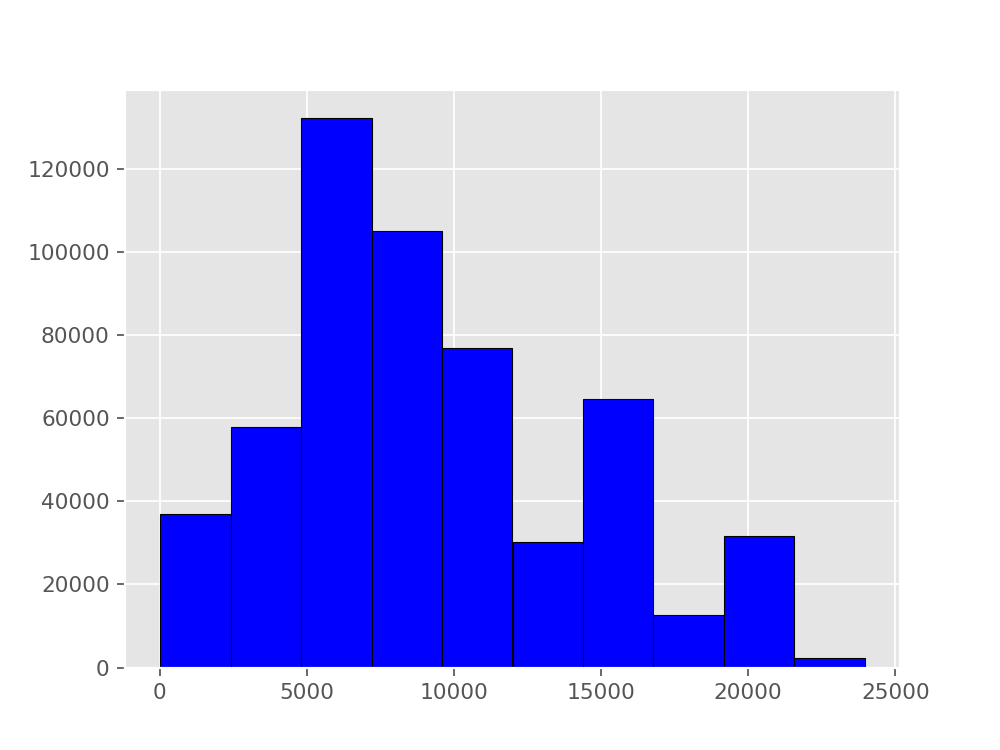

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

_ , axPur = plt.subplots()
# What is the distribution of purchases price?
df.Purchase.hist(color='b', edgecolor ='k', ax=axPur)

<IPython.core.display.Javascript object>


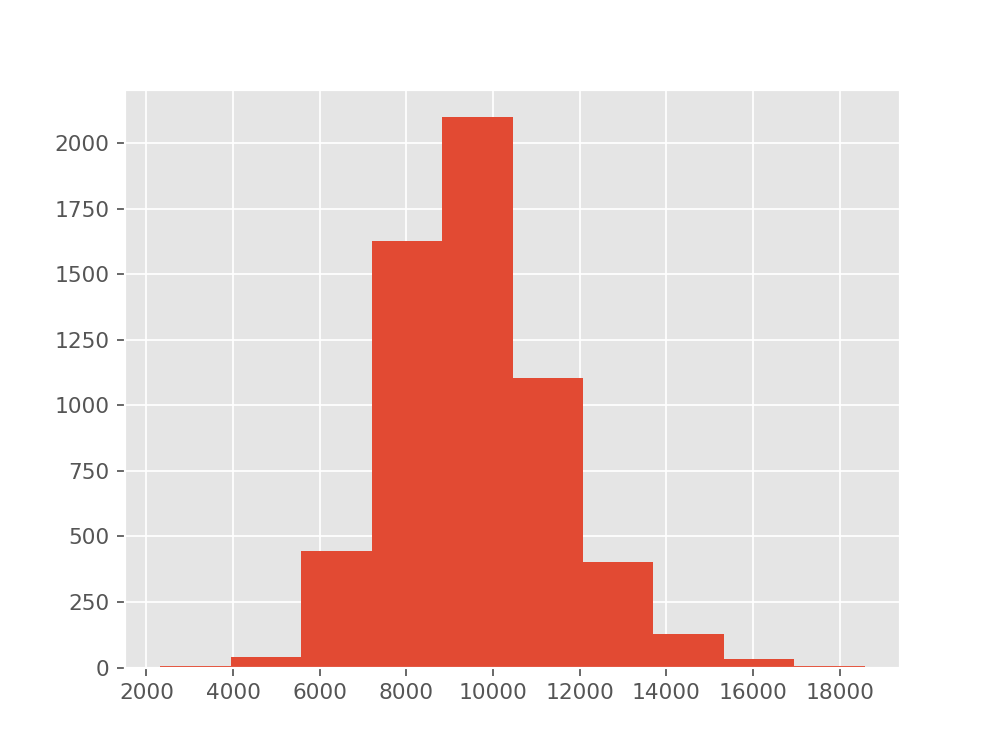

In [8]:
_ , axUID = plt.subplots()
# What is the average purchase amount per user?
df.groupby(['User_ID']).Purchase.mean().hist(ax=axUID)

<IPython.core.display.Javascript object>


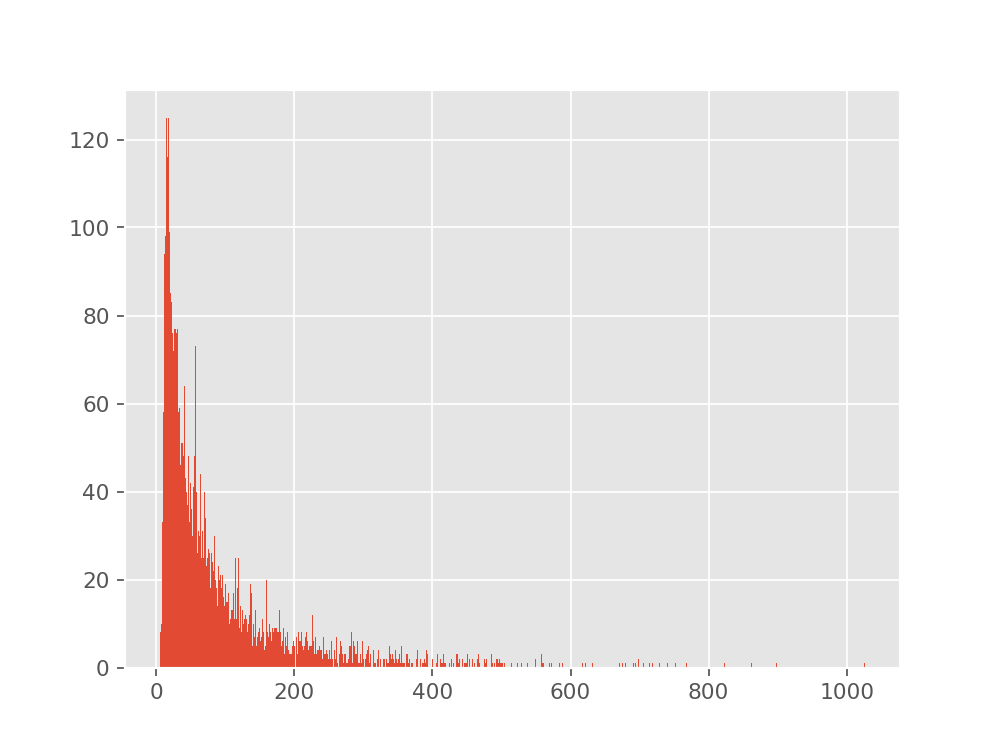

In [9]:
_ , axUIDCnt = plt.subplots()
# how many purchase instance per user ?
# df.groupby(['User_ID']).User_ID.count().hist(bins=1000, ax=axUIDCnt)
# same result
df.User_ID.value_counts().hist(bins=1000, ax=axUIDCnt)
# same again
# df.User_ID.value_counts().plot(kind='hist',bins=1000, ax=axUIDCnt)
# axUIDCnt.set_xlim(0,100)
# There is a peak around 16 purchases/user

## Gender

There are only Male or Female in this dataset, encode with arbitrary labeler (i.e. 0 and 1)

In [10]:
# how many different gender types?
df.Gender.value_counts()

M    414259
F    135809
Name: Gender, dtype: int64

In [11]:
# use scikit-learn encoder
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
Gender_encoder = LabelEncoder()
Gender_coded = Gender_encoder.fit_transform(df.Gender.values)
Gender_encoder.classes_
# sparse matrix conversion
Gender_coded = csr_matrix(Gender_coded.reshape(-1,1))

In [12]:
# ENCODING OF GENDER IN PANDAS:
# reload data for debug
# df = pd.read_csv(filename)

## gives SettingWithCopyWarning (double indexing, Gender first then boolean) but still works by chance
## 84.8 ms
# df.Gender[df.Gender == 'M'] = 0
# df.Gender[df.Gender == 'F'] = 1
# equivalent, gives SettingWithCopyWarning but works
# 99.4 ms
# df.loc[:,'Gender'][df.Gender == 'M'] = 0
# df.loc[:,'Gender'][df.Gender == 'F'] = 1

# The following statements produces SettingWithCopyWarning AND doesn't do the assigment
# typical chain indexing, meaning index twice. Make an assignment on a copy in this case!
# 95.8 ms
# df[df.Gender == 'M'].loc[:,'Gender'] = 0
# df[df.Gender == 'F'].loc[:,'Gender'] = 1

## works, no warning but not the fastest (avoid using apply because it is slow in general)
## 82.2 ms / 2 operations = 41.1 ms 
# %timeit df.loc[:,'Gender'] = df.loc[:,'Gender'].apply(lambda x: 0 if x == 'M' else 1)

# CORRECT SOLUTION single indexing, it works and fastest solution
# 20 ms !!! (faster than using sklearn encoder)
# df.loc[df.Gender == 'M', 'Gender'] = 0
# df.loc[df.Gender == 'F', 'Gender'] = 1

In [13]:
df.Gender.head()

0    F
1    F
2    F
3    F
4    M
Name: Gender, dtype: object

## Age
There are age categories, encode them via one-hot encoding scheme

In [14]:
# how many different age categories?
df.Age.value_counts()

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64

In [15]:
# use scikit-learn encoder
from sklearn.preprocessing import LabelBinarizer
Age_encoder = LabelBinarizer( sparse_output=True )
Age_coded = Age_encoder.fit_transform(df.Age.values)

# print all age categories
print(Age_encoder.classes_)
# print associated encoded values
print(Age_encoder.fit_transform(Age_encoder.classes_))
# resulting feature array should have as many columns as age categories
print(Age_coded.shape)

['0-17' '18-25' '26-35' '36-45' '46-50' '51-55' '55+']
  (0, 0)	1
  (1, 1)	1
  (2, 2)	1
  (3, 3)	1
  (4, 4)	1
  (5, 5)	1
  (6, 6)	1
(550068, 7)


## Occupation
Occupation are masked. In other words they are already encoded.<br>
Occupation are categorical so we need to use one-hot encoding.

In [16]:
# what are the different occupation ?
df.Occupation.value_counts().sort_index()

0     69638
1     47426
2     26588
3     17650
4     72308
5     12177
6     20355
7     59133
8      1546
9      6291
10    12930
11    11586
12    31179
13     7728
14    27309
15    12165
16    25371
17    40043
18     6622
19     8461
20    33562
Name: Occupation, dtype: int64

In [17]:
from sklearn.preprocessing import OneHotEncoder
# outputs sparse matrix by default
Occ_encoder = OneHotEncoder()
Occ_coded = Occ_encoder.fit_transform(df.Occupation.values.reshape(-1,1))

#  number of different values per feature (i.e. per column) encoder found 
print(Occ_encoder.n_values_ )
# resulting feature array should have as many columns as categories
print(Occ_coded.shape)

[21]
(550068, 21)


## City categories
There are 3 city categories: A, B and C.<br>
Encoded them via labelbinarizer

In [18]:
# what are the different city categories?
df.City_Category.value_counts().sort_index()

A    147720
B    231173
C    171175
Name: City_Category, dtype: int64

In [19]:
# use scikit-learn encoder
from sklearn.preprocessing import LabelBinarizer
City_encoder = LabelBinarizer(sparse_output=True)
City_coded = City_encoder.fit_transform(df.City_Category.values)

# print all categories
print(City_encoder.classes_)
# print associated encoded values
print(City_encoder.fit_transform(City_encoder.classes_))
# resulting feature array should have as many columns as categories
print(City_coded.shape)

['A' 'B' 'C']
  (0, 0)	1
  (1, 1)	1
  (2, 2)	1
(550068, 3)


## Number of year in current city
You can select 0 to 3 years then it is 4+ years.<br>
Replace 4+ with 4 years to keep only numeric values. All we know is it has been at least 4 years.


In [20]:
# years in current city
df.Stay_In_Current_City_Years.value_counts().sort_index()

0      74398
1     193821
2     101838
3      95285
4+     84726
Name: Stay_In_Current_City_Years, dtype: int64

In [21]:
from scipy.sparse import csr_matrix
Years_Current_City = df.loc[:,'Stay_In_Current_City_Years'].apply(lambda x: 4 if x == '4+' else int(x)).values
Years_Current_City_csr = csr_matrix(Years_Current_City.reshape(-1,1))
type(Years_Current_City)

numpy.ndarray

In [22]:
# try polynomes on years in current city
from sklearn.preprocessing import PolynomialFeatures
from scipy.sparse import csr_matrix
# object to compute
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
# compute polynomial features
Years_Current_City_poly = poly.fit_transform(Years_Current_City.reshape(-1,1))
# convert to sparse matrix
Years_Current_City_polycsr = csr_matrix(Years_Current_City_poly)
Years_Current_City_polycsr.shape

(550068, 3)

## Marital status
Marital status is 0 or 1. I'm guessing it means you're married if 1 otherwise you're not with 0.<br>
Can be used as given (i.e. without modifications/encoding).

In [23]:
# categories of marital status
df.Marital_Status.value_counts()

0    324731
1    225337
Name: Marital_Status, dtype: int64

In [24]:
from scipy.sparse import csr_matrix
Mar_status = df.Marital_Status.values
Mar_status = csr_matrix(Mar_status.reshape(-1,1))
Mar_status.shape

(550068, 1)

## Product Categories
Category 1 has 20 products categories (1 to 20). <br>
Category 2 has 17 products categories (2.0 to 18.0). <br>
Category 3 has 15 products categories (3.0 to 18.0, missing 7.0).

In [25]:
# categories of marital status
df.Product_Category_1.value_counts().sort_index()

1     140378
2      23864
3      20213
4      11753
5     150933
6      20466
7       3721
8     113925
9        410
10      5125
11     24287
12      3947
13      5549
14      1523
15      6290
16      9828
17       578
18      3125
19      1603
20      2550
Name: Product_Category_1, dtype: int64

In [26]:
from sklearn.preprocessing import OneHotEncoder
Prod1_encoder = OneHotEncoder()
Prod1_coded = Prod1_encoder.fit_transform(df.Product_Category_1.values.reshape(-1,1))

#  number of different values per feature (i.e. per column) encoder found 
print(Prod1_encoder.n_values_ )
# resulting feature array should have as many columns as categories
print(Prod1_coded.shape)

[21]
(550068, 20)


Product Category 1 is good to go. Let's see if we can combine all product categories

In [27]:
# NOTE: Type of Nan is float, Prod_2 and Prod_3 are float because they have missing values
temp = df.loc[:,['Product_Category_1', \
           'Product_Category_2', \
           'Product_Category_3']].astype(str)

# 155 ms ± 657 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
temp = temp.Product_Category_1 +'-'\
        +temp.Product_Category_2 +'-'\
        +temp.Product_Category_3
# 156 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# temp = temp['Product_Category_1']+'-'\
#         +temp['Product_Category_2']+'-'\
#         +temp['Product_Category_3']
# 156 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# %timeit temp = temp.loc[:,'Product_Category_1']+'-'\
#                 +temp.loc[:,'Product_Category_2']+'-'\
#                 +temp.loc[:,'Product_Category_3']
# another solution for many columns
# 156.1 ms ± 3.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# temp2 = temp.loc[:,'Product_Category_1']
# for k in range(1, len(temp.columns)):
#     temp2 = temp2 + '-' + temp.iloc[:,k]
# temp = temp2

    
# 242 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# dash_s = pd.Series('-', index=range(temp.Product_Category_1.count()))
# %timeit temp = temp.Product_Category_1.str.cat([dash_s,temp.Product_Category_2, \
#                                          dash_s, temp.Product_Category_3])

# 493.9 ms ± 15.06 ms per loop (mean ± std. dev. of 7 runs, 1 loops each)
# dash_s = pd.Series('-', index=range(temp.Product_Category_1.count()))
# for k in range(1, len(temp.columns)+1, 2):
#     temp.insert(k, 'dash', dash_s, allow_duplicates=True)
# temp = temp.sum(axis=1)

# 7.67 s ± 20.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# using apply and axis=1 is the worst!
# %timeit temp = temp.apply(lambda x:'-'.join(x) , axis=1 )


# combine Prod_1, Prod_2 and Prod_3 in one shot, slowest!
# 14.9 s ± 289 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# %timeit temp = df.apply(lambda x:\
#             '-'.join([str(x['Product_Category_1']),\
#                       str(x['Product_Category_2']), \
#                       str(x['Product_Category_3']), \
#                      ]), axis=1 )


# name of column in newly created pandas series
temp.name='Prod_cat123'

In [28]:
# # Timing test only
# import timeit
# setup = """\
# import pandas as pd
# filename = './train_oSwQCTC/train.csv'
# df = pd.read_csv(filename)
# temp = df.loc[:,['Product_Category_1', \
#            'Product_Category_2', \
#            'Product_Category_3']].astype(str)"""
# s = """\
# temp2 = temp.loc[:,'Product_Category_1']
# for k in range(1, len(temp.columns)):
#     temp2 = temp2 + '-' + temp.iloc[:,k]
# """
# s2 = """\
# temp2 = temp.loc[:,'Product_Category_1']+'-'\
#                 +temp.loc[:,'Product_Category_2']+'-'\
#                 +temp.loc[:,'Product_Category_3']"""
# s3 = """\
# dash_s = pd.Series('-', index=range(temp.Product_Category_1.count()))
# for k in range(1, len(temp.columns)+1, 2):
#     temp.insert(k, 'dash', dash_s, allow_duplicates=True)
# temp2 = temp.sum(axis=1)"""
# runs = 7
# loops = 1
# ts = timeit.repeat(stmt=s3, setup=setup, repeat=runs, number=loops)
# import numpy as np
# tsarr = np.array(ts)/loops
# print('{:.1f} ms ± {:.2f} ms per loop (mean ± std. dev. of {} runs, {} loops each)'.format(\
#         tsarr.mean()*1e3,tsarr.std()*1e3, runs, loops))

In [29]:
# temp.Product_Category_1.apply(type)
# temp.loc[:10, 'Product_Category_3']
temp.iloc[:5]

0      3-nan-nan
1     1-6.0-14.0
2     12-nan-nan
3    12-14.0-nan
4      8-nan-nan
Name: Prod_cat123, dtype: object

In [30]:
# number of different (Prod1-Prod2-Prod3) combination
temp.value_counts().count()

237

In [31]:
# use scikit-learn encoder
from sklearn.preprocessing import LabelBinarizer
Prod_encoder = LabelBinarizer(sparse_output=True)
Prod_coded = Prod_encoder.fit_transform(temp.values)

# print all categories
print(Prod_encoder.classes_[:5])
# print associated encoded values
print(Prod_encoder.fit_transform(Prod_encoder.classes_)[:5])
# resulting feature array should have as many columns as categories
print(Prod_coded.shape)

['1-11.0-15.0' '1-11.0-16.0' '1-11.0-nan' '1-13.0-14.0' '1-13.0-15.0']
  (0, 0)	1
  (1, 1)	1
  (2, 2)	1
  (3, 3)	1
  (4, 4)	1
(550068, 237)


<IPython.core.display.Javascript object>


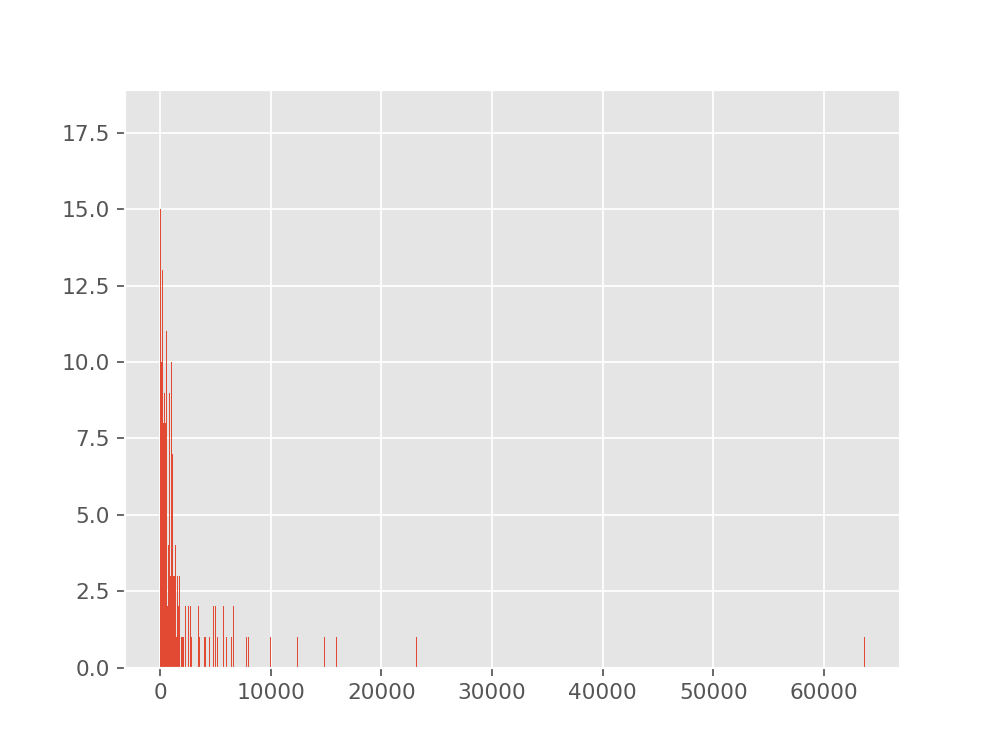

In [32]:
# distribution of Product Cat123 instance
_ , axPcat = plt.subplots()
ProdCat_distrib = temp.value_counts()
ProdCat_distrib.hist( ax=axPcat, bins=1000 )

In [33]:
ProdCat_distrib.describe()

count      237.000000
mean      2320.962025
std       6394.505314
min          1.000000
25%        277.000000
50%        758.000000
75%       1703.000000
max      63700.000000
Name: Prod_cat123, dtype: float64

In [34]:
ProdCat_distrib[ProdCat_distrib <100 ].count()

19

## User ID

In [35]:
# use scikit-learn encoder
from sklearn.preprocessing import LabelBinarizer
User_encoder = LabelBinarizer(sparse_output=True)
User_coded = User_encoder.fit_transform(df.User_ID.values)

# print all categories
print(User_encoder.classes_[:5])
# print associated encoded values
print(User_encoder.fit_transform(User_encoder.classes_)[:5])
# resulting feature array should have as many columns as categories
print(User_coded.shape)

# users are already encoded, only need one-hot encoding
#TODO (optional)

[1000001 1000002 1000003 1000004 1000005]
  (0, 0)	1
  (1, 1)	1
  (2, 2)	1
  (3, 3)	1
  (4, 4)	1
(550068, 5891)


In [36]:
df.loc[:3,'User_ID'].apply(type)

0    <class 'int'>
1    <class 'int'>
2    <class 'int'>
3    <class 'int'>
Name: User_ID, dtype: object

In [37]:
UserID_distrib = df.User_ID.value_counts()
# Number of User ID that occurs less than 10 times
UserID_distrib[UserID_distrib < 10].count()

40

In [38]:
UserID_distrib.describe()

count    5891.000000
mean       93.374300
std       107.190049
min         6.000000
25%        26.000000
50%        54.000000
75%       117.000000
max      1026.000000
Name: User_ID, dtype: float64

## Product ID

In [39]:
# number of different products
df.Product_ID.value_counts().count()

3631

<IPython.core.display.Javascript object>


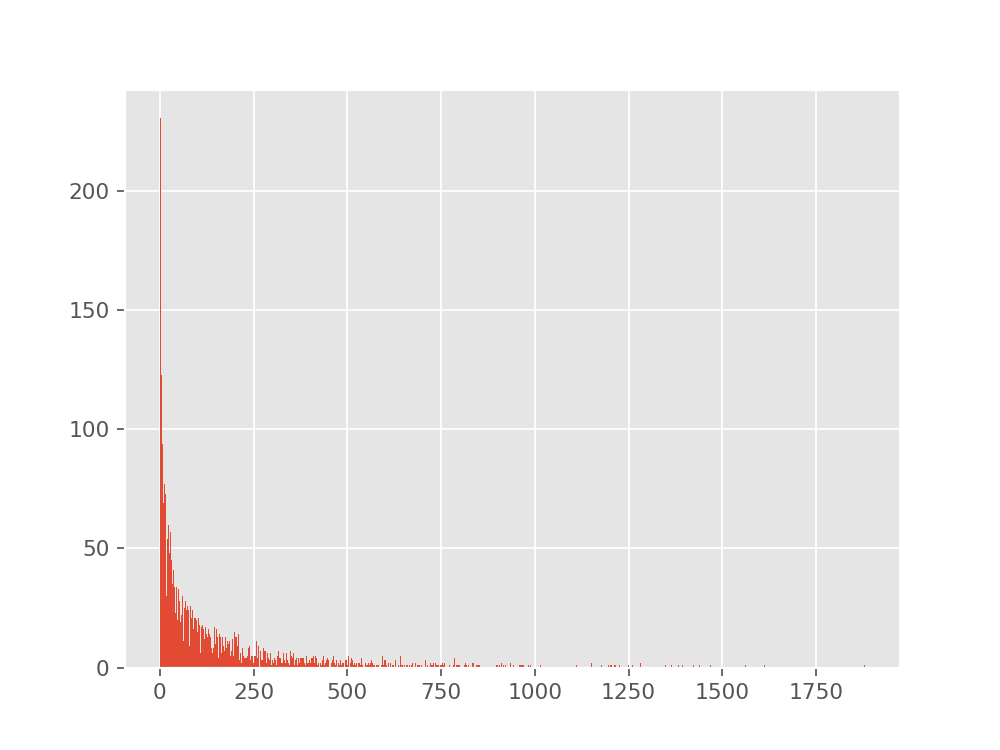

In [40]:
# distribution of Product ID instance
_ , axPID = plt.subplots()
ProdID_distrib = df.Product_ID.value_counts()
ProdID_distrib.hist(ax=axPID, bins=1000)
plt.show()

In [41]:
# Number of product ID that occurs once only
ProdID_distrib[ProdID_distrib == 1].count()

144

In [42]:
# Number of product ID that occurs less than 10 times
ProdID_distrib[ProdID_distrib < 10].count()

560

In [43]:
ProdID_distrib.describe()

count    3631.000000
mean      151.492151
std       212.852932
min         1.000000
25%        19.500000
50%        71.000000
75%       194.000000
max      1880.000000
Name: Product_ID, dtype: float64

144 products have only one instance (purchased once only)<br>
560 products have less than 10 instances.<br>
One could add weights according to Product ID

In [44]:
# use scikit-learn encoder
from sklearn.preprocessing import LabelBinarizer
ProdID_encoder = LabelBinarizer(sparse_output=True)
ProdID_coded = ProdID_encoder.fit_transform(df.Product_ID.values)

# print all categories
print(ProdID_encoder.classes_[:5])
# print associated encoded values
print(ProdID_encoder.fit_transform(ProdID_encoder.classes_)[:5])
# resulting feature array should have as many columns as categories
print(ProdID_coded.shape)

['P00000142' 'P00000242' 'P00000342' 'P00000442' 'P00000542']
  (0, 0)	1
  (1, 1)	1
  (2, 2)	1
  (3, 3)	1
  (4, 4)	1
(550068, 3631)


### Does each Product ID refer to a unique product category?
This is a sanity check to make sure the same product ID was NOT given 2 different product category 123.

In [45]:
# Group by product ID and see if each Product ID occurrence has a unique Product category triplet
df_ProdIDCat = pd.concat([df.loc[:,'Product_ID'], temp], axis=1)
df_ProdIDCat.count()

Product_ID     550068
Prod_cat123    550068
dtype: int64

In [46]:
# this produces an empty dataframe as they are no remaining data (only two columns)
# BUT index has tuples and if the first element repeats in more than one tuples then
# they are Product ID that fits in different category triplet
# s = df_ProdIDCat.groupby(['Product_ID', 'Product_Cat123']).count()

# group by Prod ID then count the different Prod cat triplet for each Prod ID
s = df_ProdIDCat.groupby(['Product_ID']).Prod_cat123.value_counts()
# compare size of first level index (size of Prod ID returns the number of unique ProdID)
# to second level index (Prod Cat triplet, get all values as list and use length so that
# it doesn't only count unique values)
print(s.index.levels[0].size)
print(len(s.index.get_level_values(1)))
# NOTE: get_level_values()  returns a Int64Index object, len() and .shape work on it.
# SIDE NOTE: List uses len(), numpy array uses .shape

# # EXTRA: filter df_ProdIDCat by product (too slow!)
# for ind, ID in df.Product_ID.value_counts().iteritems():
#     if df_ProdIDCat[df_ProdIDCat.Product_ID == ID].Product_Cat123.value_counts().size > 1:
#         print(ind,ID)

3631
3631


Conclusion is each product ID belongs to a unique Prod Cat123

## Combination of Age and Marital Status and City Category

In [47]:
# make sure everything is a string
temp_Age_Marital_City = df.loc[:,['Age', \
           'Marital_Status', \
           'City_Category']].astype(str)

# merge content of columns
temp_Age_Marital_City = temp_Age_Marital_City.Age +'-'\
        +temp_Age_Marital_City.Marital_Status +'-'\
        +temp_Age_Marital_City.City_Category
        
# assign name to new column
temp_Age_Marital_City.name = 'Age_Marital_City'

In [48]:
temp_Age_Marital_City.value_counts()

26-35-0-B    56191
26-35-0-A    46374
26-35-1-B    35393
18-25-0-B    33663
26-35-0-C    30731
36-45-0-B    30130
26-35-1-A    27371
26-35-1-C    23527
18-25-0-C    23088
18-25-0-A    21793
36-45-0-C    21524
36-45-1-B    17468
46-50-1-B    15553
36-45-0-A    14723
36-45-1-C    14274
51-55-1-B    12969
46-50-1-C    12287
36-45-1-A    11894
51-55-1-C    10372
18-25-1-B     9584
55+-1-C       8088
0-17-0-C      7123
18-25-1-C     5790
18-25-1-A     5742
0-17-0-B      5435
46-50-0-C     5401
46-50-1-A     5171
46-50-0-B     4853
51-55-0-B     4772
55+-0-C       4681
51-55-1-A     4321
51-55-0-C     4289
55+-1-B       3485
0-17-0-A      2544
46-50-0-A     2436
55+-1-A       2048
51-55-0-A     1778
55+-0-B       1677
55+-0-A       1525
Name: Age_Marital_City, dtype: int64

In [49]:
# use scikit-learn encoder
from sklearn.preprocessing import LabelBinarizer
Age_Marital_City_encoder = LabelBinarizer(sparse_output=True)
Age_Marital_City_coded = Age_Marital_City_encoder.fit_transform(temp_Age_Marital_City.values)

# Linear Regression


In [50]:
df.head(2)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200


In [104]:
import numpy as np
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.linear_model import LinearRegression
# fit_intercept=True adds bias/intercept so that we don't have to worry about it.
model = LinearRegression(n_jobs=-1, normalize=False, fit_intercept=True)
# n_jobs doesn't speed up because I only have one target (Purchase)
#TODO, add sample_weight to fit() higher weights for underrepresented prod cat

# Years_Current_City_poly
# intercept = csr_matrix( np.ones((Gender_coded.shape[0],1))*1 )
# X = Prod_coded.toarray()
# X = np.concatenate(( np.ones((Gender_coded.shape[0],1)) , Prod_coded.toarray() ), axis=1)
# X = hstack( (Gender_coded,\
#              Age_coded,\
#              Occ_coded,\
#              City_coded,\
#              Years_Current_City_csr,\
#              Mar_status,\
#              ProdID_coded,\
#              User_coded,\
#              Prod_coded ))
# X = hstack( ( Gender_coded,\
#              Age_Marital_City_coded,\
#              Years_Current_City_csr,\
#              Occ_coded,\
#              User_coded,\
#              ProdID_coded,\
#              Prod_coded ))
X = hstack( ( Gender_coded,\
             User_coded,\
             ProdID_coded,\
             Prod_coded ))
y = df.Purchase.values
model.fit(X, y)
model.intercept_, model.coef_[0], model.coef_.shape, X.shape

(9263.9687129591257, 53.724533826525445, (9760,), (550068, 9760))

In [105]:
from sklearn.metrics import r2_score
y_pred = model.predict(X)
print('Chi-Square = {:.4f}'.format(r2_score(y, y_pred)))

from sklearn.metrics import mean_squared_error
print('MSE = {:.4f}'.format(mean_squared_error(y, y_pred)))
print('RMSE = {:.4f}'.format(np.sqrt(mean_squared_error(y, y_pred))))

Chi-Square = 0.7608
MSE = 6034115.0515
RMSE = 2456.4436


# Am I overfitting (high variance)? underfitting? (high bias)

There is a gap of about 100 RSME which is small compared to our 2500 RSME of our model.<br>
Thus it is mostly underfitting..

The exact solution is  x = 0                              


<IPython.core.display.Javascript object>


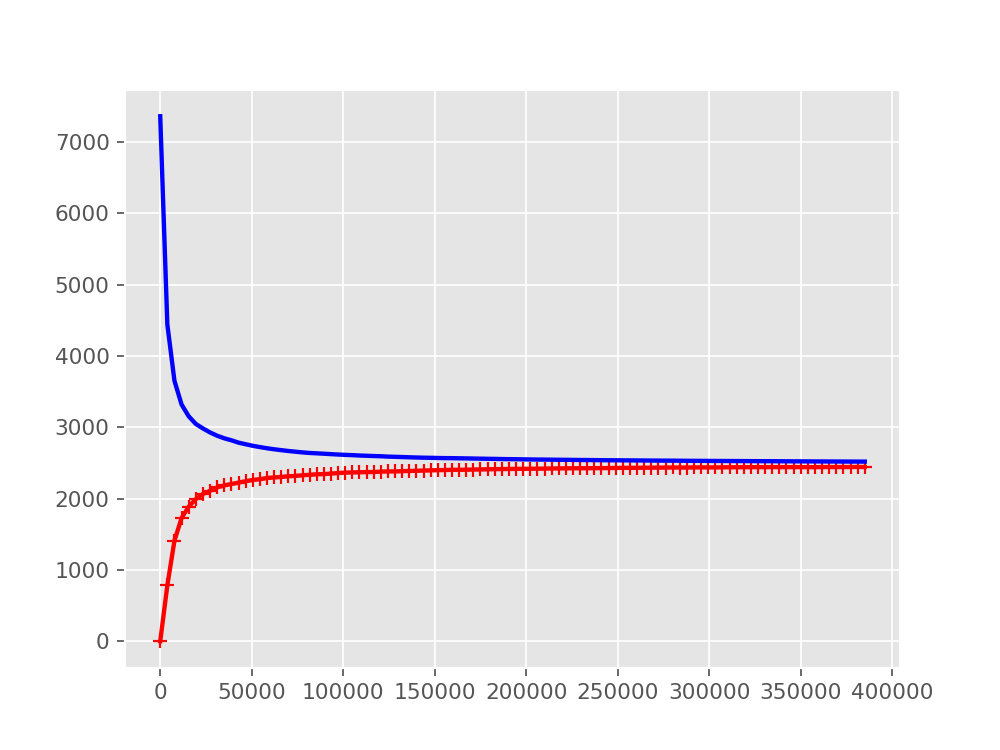

In [53]:
from sklearn.model_selection import train_test_split
import numpy as np

def plot_learning_curve(model,X,y):
    # split data/target in train and test sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    train_errors, val_errors = [], []
    train_sizes = np.linspace(1, X_train.shape[0], 100, dtype='int64')
    for m in train_sizes:
        # train with m samples
        model.fit(X_train[:m], y_train[:m])
        # predict training data and val data
        y_train_pred = model.predict(X_train[:m])
        y_val_pred = model.predict(X_val)
        # save MSE metric
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        val_errors.append(mean_squared_error(y_val, y_val_pred))
    _ , ax = plt.subplots()
    ax.plot(train_sizes, np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    ax.plot(train_sizes, np.sqrt(val_errors), 'b-', linewidth=2, label='validation')
    plt.show()

plot_learning_curve(model,X,y)

### Examples where the error is very large or very low
Best and worst example have the same magnitude! (1e-8 to 1e8 error)

In [54]:
# # draft to remove
# df.iloc[0,:]
# len(df_worst.columns)
# df_worst.columns
# print(RareProdID.name)
# sqerr_asc.shape
# df_worst.loc[df_worst.User_ID.isin(UserWorst_distrib_filt.index), :].count()
# UserWorst_distrib_filt.sum()

In [55]:
import numpy as np

# RMSE, match scikit-learn sqrt(mean_squared_error) metric
# np.sqrt( (1/y.shape[0])*sum((y-y_pred)**2) )

# restraint data to topnb
# topnb = 100
# square error, ascending order
sqerr_asc = np.sort((y-y_pred)**2)
# sqerr_asc_ind = np.argsort((y-y_pred)**2)
# print('Top 10 Lowest Square Error {}'.format(sqerr_asc[:topnb]))
# print('Corresponding indices {}'.format(sqerr_asc_ind[:topnb]))

# descending order
# sqerr_dsc = sqerr_asc[::-1]
# sqerr_dsc_ind = sqerr_asc_ind[::-1]
# print('Top 10 Highest Square Error {}'.format(sqerr_dsc[:topnb]))
# print('Corresponding indices {}'.format(sqerr_dsc_ind[:topnb]))

# # retrieve User ID from X (better to come back to the original dataframe)
# # order has not been changed during training
# X_best = X.tocsr()[sqerr_asc_ind[:topnb], :User_coded.shape[1]]
# X_worst = X.tocsr()[sqerr_dsc_ind[:topnb], :User_coded.shape[1]]
# UserID_worst = User_encoder.inverse_transform(X_worst)
# print('UserID for worst cases {}'.format(UserID_worst))

# compare rare product ID to worst predictions
# Keep topnb instances
# df_worst = df.loc[sqerr_dsc_ind[:topnb], :].copy()
# At square_error = 5e7, error rises dramatically
df_worst = df.loc[sqerr_asc > 5e7, :].copy()

# add Prod cat123 and remove individual Prod cat
temp_w = df_worst.loc[:,['Product_Category_1', \
           'Product_Category_2', \
           'Product_Category_3']].astype(str)
temp_w = temp_w.Product_Category_1 +'-'\
        +temp_w.Product_Category_2 +'-'\
        +temp_w.Product_Category_3
# df_worst['Prod_cat123'] = temp_w
df_worst.insert(len(df_worst.columns)-1, 'Prod_cat123', temp_w)
df_worst.drop(labels = ['Product_Category_1','Product_Category_2','Product_Category_3'],\
              inplace=True, axis = 1)

# look at a few examples
df_worst.describe(include='all')

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Prod_cat123,Purchase
count,8.013000e+03,8013,8013,8013,8013.000000,8013,8013,8013.000000,8013,8013.000000
unique,NaN,1562,2,7,NaN,3,5,NaN,205,NaN
top,NaN,P00371644,M,26-35,NaN,C,1,NaN,20-nan-nan,NaN
freq,NaN,899,5710,3200,NaN,3251,2779,NaN,2550,NaN
mean,1.004347e+06,NaN,NaN,NaN,7.856982,NaN,NaN,0.443280,NaN,4573.781231
std,1.850011e+03,NaN,NaN,NaN,6.516427,NaN,NaN,0.496803,NaN,5665.652011
min,1.000001e+06,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,12.000000
25%,1.002947e+06,NaN,NaN,NaN,1.000000,NaN,NaN,0.000000,NaN,137.000000
50%,1.005504e+06,NaN,NaN,NaN,7.000000,NaN,NaN,0.000000,NaN,606.000000
75%,1.005767e+06,NaN,NaN,NaN,14.000000,NaN,NaN,1.000000,NaN,7963.000000


In [56]:
def print_rare_cases(Rare):
    Rare_HighErr = df_worst[Rare.name].isin(Rare.index).sum()
    print( 'Number of rare {} having high error = {} out of {} ({:.2f}%)'.format(\
    Rare.name, Rare_HighErr, Rare.count(), Rare_HighErr/Rare.count()*100) )

# Almost None of the rare product ID corresponds to the worst cases
RareProdID = ProdID_distrib[ProdID_distrib < 5]
print_rare_cases(RareProdID)
# what about rare users?
# rare user is defined as less than 10-16 occurrence (see distribution of users)
RareUsers = UserID_distrib[UserID_distrib < 16]
print_rare_cases(RareUsers)
# what about Prod cat123?
RareProdCat123 = ProdCat_distrib[ProdCat_distrib < 100]
print_rare_cases(RareProdCat123)

# print total number identified as high error
print('Number of worst instances = {}'.format(df_worst.Purchase.count()))

Number of rare Product_ID having high error = 5 out of 354 (1.41%)
Number of rare User_ID having high error = 375 out of 525 (71.43%)
Number of rare Prod_cat123 having high error = 4 out of 19 (21.05%)
Number of worst instances = 8013


<IPython.core.display.Javascript object>


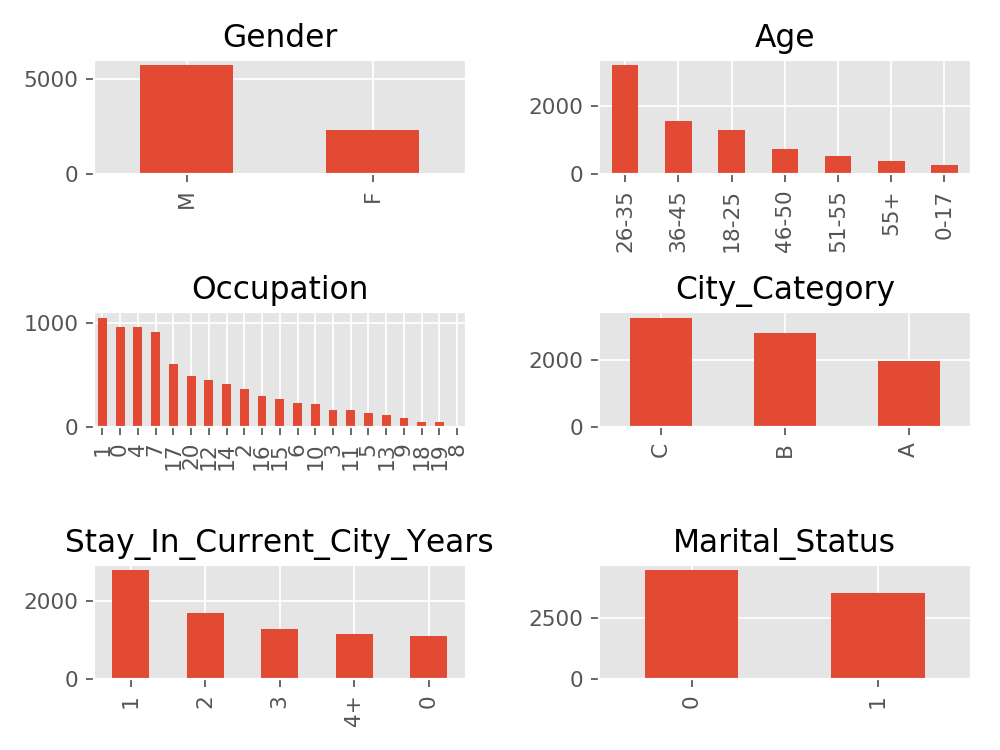

<IPython.core.display.Javascript object>


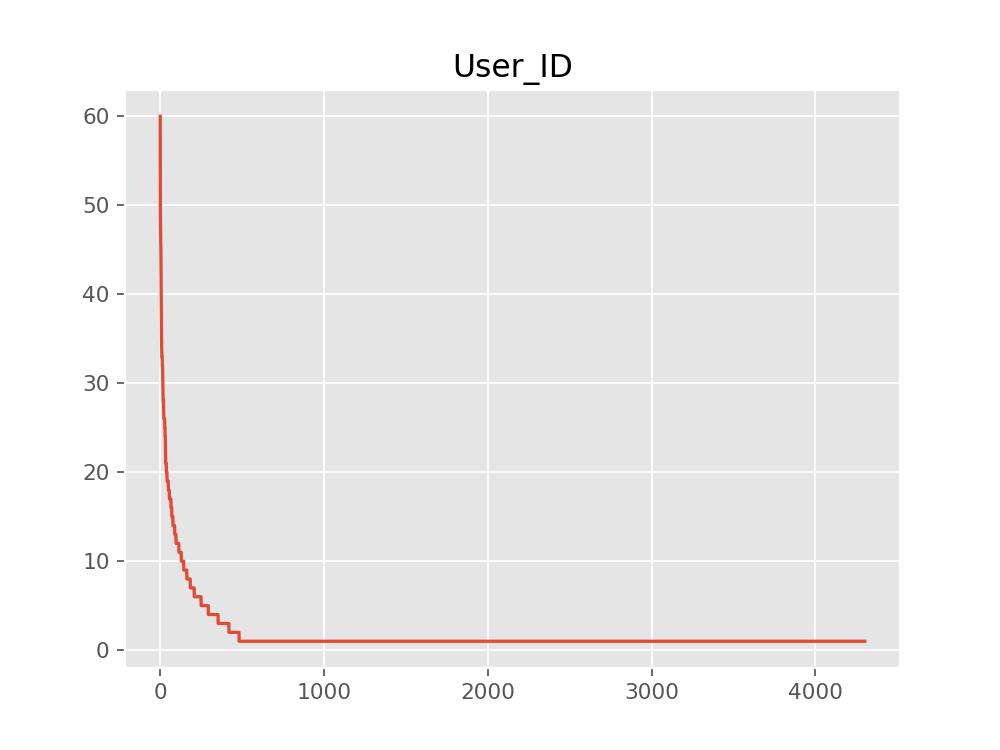

<IPython.core.display.Javascript object>


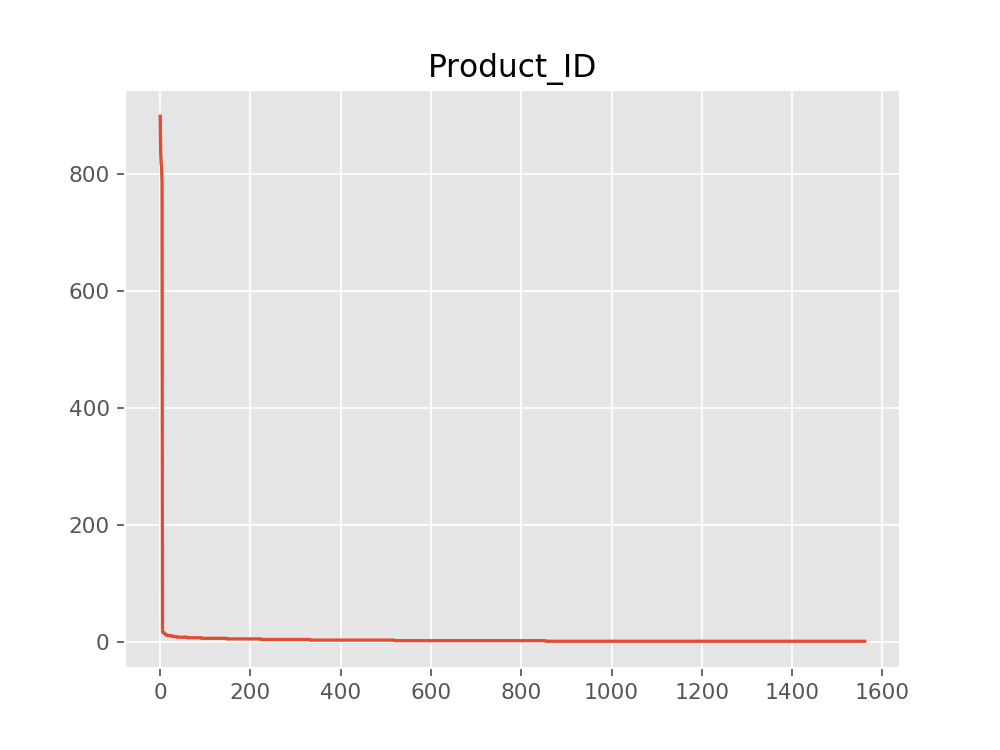

<IPython.core.display.Javascript object>


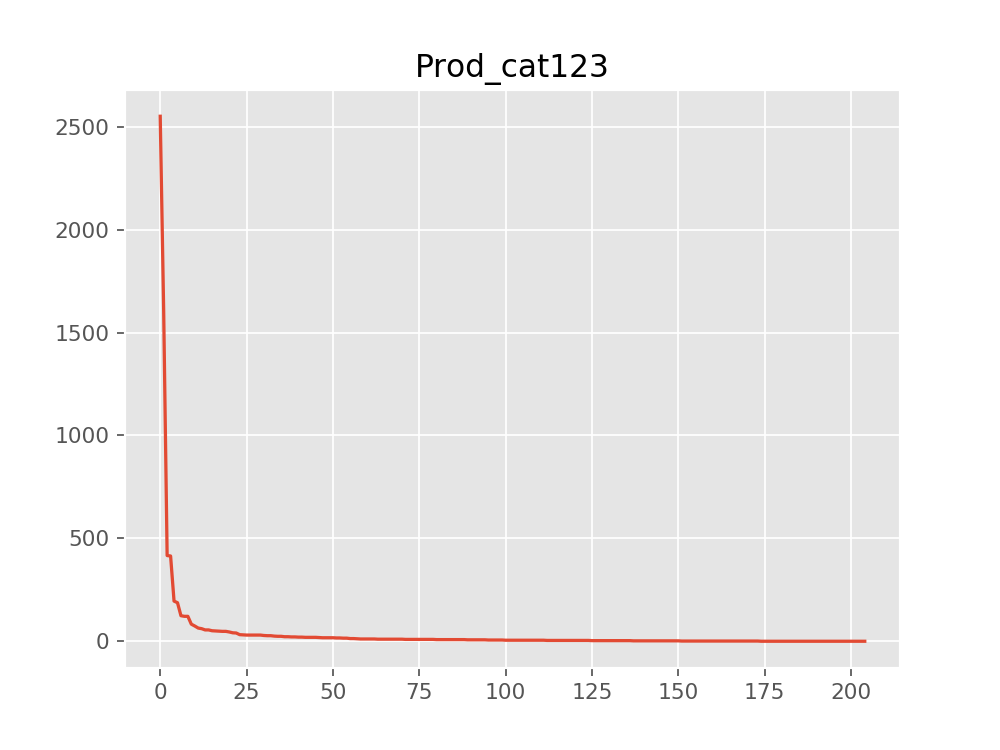

<IPython.core.display.Javascript object>


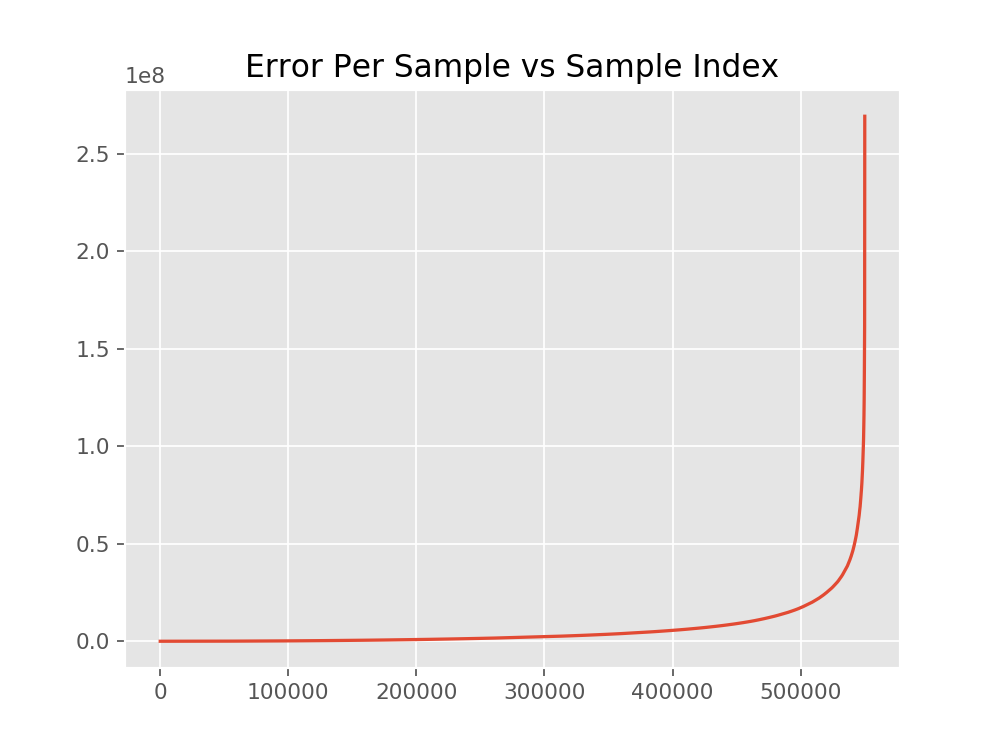

Text(0.5,1,'Error Per Sample vs Sample Index')

In [57]:
# Make plots for each features from worst subset
cat_list = ['Gender', 'Age', 'Occupation',\
            'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']
_ , axw = plt.subplots(3, 2)
axw = axw.flatten()
# for k in range(len(df_worst.columns)-1):
for k, colname in enumerate(cat_list):
    dis = df_worst.loc[:, colname]
    dis.value_counts().plot(kind='bar', ax=axw[k])
    axw[k].set_title(dis.name)
plt.tight_layout()

_ , axw2 = plt.subplots()
# value_counts() sort value in descending order by default
UserWorst_distrib = df_worst.loc[:, 'User_ID'].value_counts()
# UserWorst_distrib.plot(kind='bar', ax=axw2)
axw2.plot(range(UserWorst_distrib.count()) , UserWorst_distrib.values)
axw2.set_title(df_worst.User_ID.name)

_ , axw3 = plt.subplots()
ProdIDWorst_distrib = df_worst.Product_ID.value_counts()
# ProdIDWorst_distrib.plot(kind='bar', ax=axw3)
axw3.plot(range(ProdIDWorst_distrib.count()) , ProdIDWorst_distrib.values)
axw3.set_title(df_worst.Product_ID.name)

_ , axw4 = plt.subplots()
ProdCatWorst_distrib = df_worst.Prod_cat123.value_counts()
# ProdCatWorst_distrib.plot(kind='bar', ax=axw4)
axw4.plot(range(ProdCatWorst_distrib.count()) , ProdCatWorst_distrib.values)
axw4.set_title(df_worst.Prod_cat123.name)

_ , axsq = plt.subplots()
axsq.plot(sqerr_asc)
axsq.set_title('Error Per Sample vs Sample Index')

plt.show()

Most Users where we get a very large error happens once. This unique case could be treated as outliers.<br>
Below we see those users have a wide range of instance in the whole dataset. As wide as the whole dataset. So again we could treat them as outliers as we have more instances for each user.

<IPython.core.display.Javascript object>


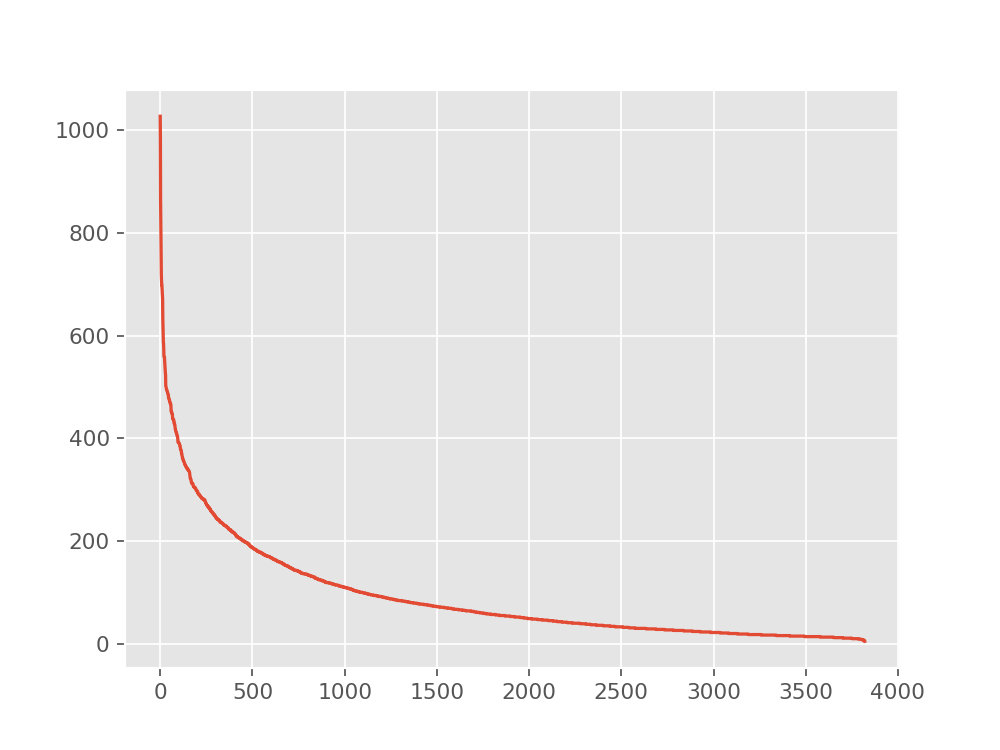

In [58]:
# only keep users with one instance from worst subset
UserWorst_distrib_filt = UserWorst_distrib[UserWorst_distrib == 1]

# total number of instances where user got it wrong by far only once (it is minimum 6)
# U = UserID_distrib.loc[UserID_distrib.index.isin(UserWorst_distrib_filt.index)]

U = UserWorst_distrib_filt.align(UserID_distrib, join='left', axis=0)
U = U[1].sort_values(ascending=False)
# align return a tuple of series (resulting left, resulting right), not sorted

_ , axw5 = plt.subplots()
axw5.plot(range(U.count()) , U.values)
plt.show()

In [59]:
# Similar analysis for best cases
df_best = df.loc[sqerr_asc < 100, :].copy()
# print( df_best['Product_ID'].isin(ProdID_distrib[ProdID_distrib == 1].index).sum() )
# print('Number of best instances = {}'.format(df_best.Purchase.count()))

# _ , axb = plt.subplots()
# df_best.hist(ax=axb)

In [60]:
# PURCHASE
# looking at a portion of worst prediction, there is a peak in purchase between 0 and 2400
df_worst.loc[df_worst.Purchase < 2400, 'Purchase'].count()
# this peak represents only 1/10th of total instance in that purchase range
df.loc[df.Purchase < 2400, 'Purchase'].count()

36840

# Linear Regression (outliers removed)

In [61]:
import numpy as np
from scipy.sparse import hstack
from sklearn.linear_model import LinearRegression
# fit_intercept=True adds bias/intercept so that we don't have to worry about it.
model_outliers = LinearRegression(n_jobs=-1, normalize=False, fit_intercept=True)
# n_jobs doesn't speed up because I only have one target (Purchase)

# filter out outliers, make a copy of original df
# df_worst_filt = df_worst.loc[df_worst.User_ID.isin(UserWorst_distrib_filt.index), :]
df_outliers = df.drop(df_worst.index, axis=0)


User_coded_outliers = User_encoder.transform(df_outliers.User_ID.values)
ProdID_coded_outliers = ProdID_encoder.transform(df_outliers.Product_ID.values)
# combine Prod_1, Prod_2 and Prod_3
temp_outliers = df_outliers.loc[:,['Product_Category_1', \
           'Product_Category_2', \
           'Product_Category_3']].astype(str)
temp_outliers = temp_outliers.Product_Category_1 +'-'\
        +temp_outliers.Product_Category_2 +'-'\
        +temp_outliers.Product_Category_3
Prod_coded_outliers = Prod_encoder.transform(temp_outliers.values)

X2 = hstack( ( User_coded_outliers,\
             ProdID_coded_outliers,\
             Prod_coded_outliers ))

y2 = df_outliers.Purchase.values
model_outliers.fit(X2, y2)
model_outliers.intercept_, model_outliers.coef_[0], model_outliers.coef_.shape, X2.shape

(9333.3020320816158, 131.52818207419512, (9759,), (542055, 9759))

In [62]:
from sklearn.metrics import r2_score
y_pred2 = model_outliers.predict(X2)
print('Chi-Square = {:.4f}'.format(r2_score(y2, y_pred2)))

from sklearn.metrics import mean_squared_error
print('MSE = {:.4f}'.format(mean_squared_error(y2, y_pred2)))
print('RMSE = {:.4f}'.format(np.sqrt(mean_squared_error(y2, y_pred2))))

Chi-Square = 0.7553
MSE = 6069439.1632
RMSE = 2463.6232


### Run learning curve on that model

The exact solution is  x = 0                              


<IPython.core.display.Javascript object>


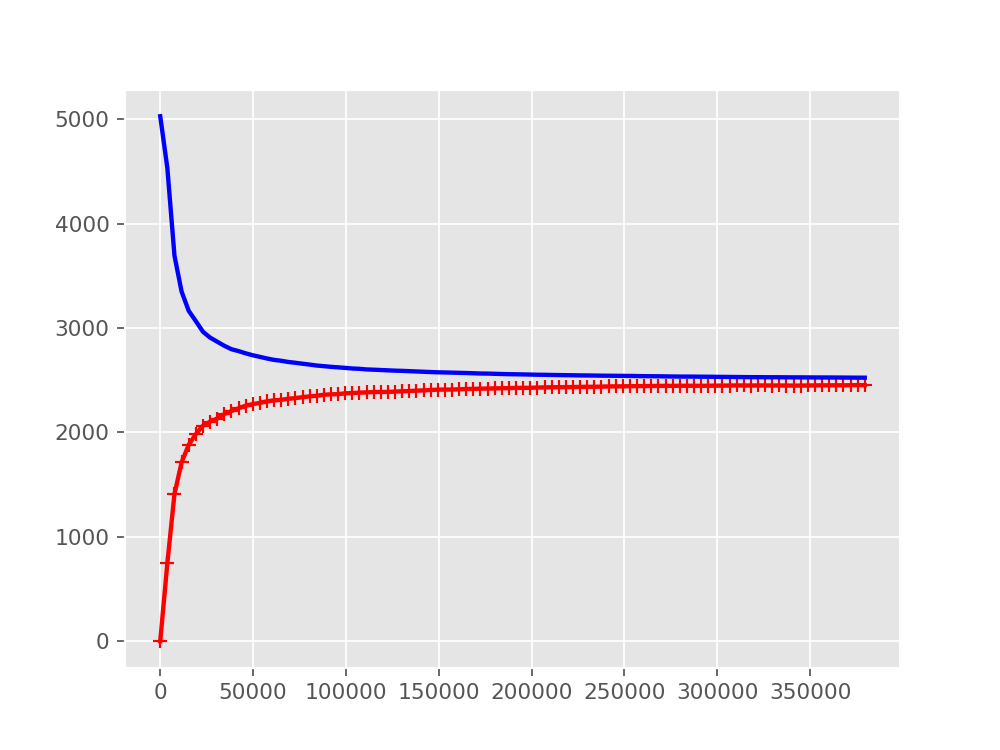

In [63]:
plot_learning_curve(model_outliers,X2,y2)

# Linear Regression (SGD version)
SGD: Stochastic Gradient Descent

In [64]:
from sklearn.linear_model import SGDRegressor
model_SGD = SGDRegressor(max_iter=50, penalty=None, eta0=0.1, tol=1e-3, shuffle=True)
model_SGD.fit(X, y)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=50, n_iter=None, penalty=None,
       power_t=0.25, random_state=None, shuffle=True, tol=0.001, verbose=0,
       warm_start=False)

In [65]:
y_predSGD = model_SGD.predict(X)
from sklearn.metrics import mean_squared_error
print('MSE = {:.4f}'.format(mean_squared_error(y, y_predSGD)))
print('RMSE = {:.4f}'.format(np.sqrt(mean_squared_error(y, y_predSGD))))

MSE = 6048695.3689
RMSE = 2459.4096


In [66]:
model_SGD.n_iter_

45

# Test results Linear Regression
Run algo on test data to submit answer.<br>
Apply previous encoders to run model on test data set.

In [155]:
filename = './test_HujdGe7/test.csv'
df_test = pd.read_csv(filename)

# from scipy.sparse import csr_matrix
# Years_Current_City_t = df_test.loc[:,'Stay_In_Current_City_Years'].apply(\
#                                                 lambda x: 4 if x == '4+' else int(x)).values
# Years_Current_City_t = csr_matrix(Years_Current_City_t.reshape(-1,1))
User_coded_t = User_encoder.transform(df_test.User_ID.values)
ProdID_coded_t = ProdID_encoder.transform(df_test.Product_ID.values)
# combine Prod_1, Prod_2 and Prod_3
temp_t = df_test.loc[:,['Product_Category_1', \
           'Product_Category_2', \
           'Product_Category_3']].astype(str)
temp_t = temp_t.Product_Category_1 +'-'\
        +temp_t.Product_Category_2 +'-'\
        +temp_t.Product_Category_3
Prod_coded_t = Prod_encoder.transform(temp_t.values)

# # combine age, marital status and city
# temp_Age_Marital_City_t = df_test.loc[:,['Age', \
#            'Marital_Status', \
#            'City_Category']].astype(str)
# # merge content of columns
# temp_Age_Marital_City_t = temp_Age_Marital_City_t.Age +'-'\
#         +temp_Age_Marital_City_t.Marital_Status +'-'\
#         +temp_Age_Marital_City_t.City_Category
# # assign name to new column
# temp_Age_Marital_City_t.name = 'Age_Marital_City'
# Age_Marital_City_coded_t = Age_Marital_City_encoder.transform(temp_Age_Marital_City_t.values)

# Occ_coded_t = Occ_encoder.transform(df_test.Occupation.values.reshape(-1,1))
Gender_coded_t = Gender_encoder.transform(df_test.Gender.values)
Gender_coded_t = csr_matrix(Gender_coded_t.reshape(-1,1))
# Intercept_t = csr_matrix(np.ones( (Gender_coded_t.shape[0],1) ) )

# X_test = hstack( ( Years_Current_City_t,\
#              Gender_coded_t,\
#              Age_Marital_City_coded_t,\
#              Occ_coded_t,\
#              User_coded_t,\
#              ProdID_coded_t,\
#              Prod_coded_t ) )
X_test = hstack( (Gender_coded_t,\
                  User_coded_t,\
             ProdID_coded_t,\
             Prod_coded_t ) )

y_pred_test = tree_reg.predict(X_test)
print('Done')

Done


In [156]:
df_results = df_test.loc[:,('User_ID','Product_ID')]
df_results['Purchase'] = y_pred_test.reshape(-1,1)
df_results.to_csv('Submission.csv', index=False)

# Correlation
Let's see what correlation between features tells us PRIOR TO FEATURE EXTRACTION.

<IPython.core.display.Javascript object>


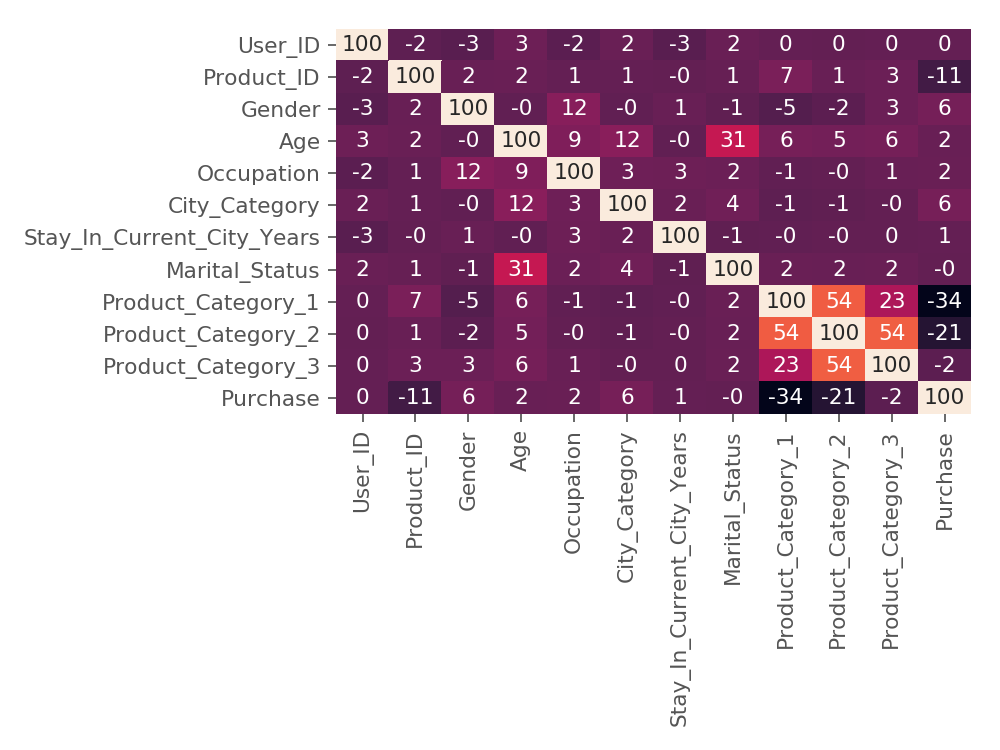

In [116]:
# start with a dataframe copy
df_cpy = df.copy()
# one needs to encode categorical values first
# use scikit-learn encoder
from sklearn.preprocessing import LabelEncoder
Gender = LabelEncoder()
df_cpy.Gender = Gender.fit_transform(df.Gender.values)
Age = LabelEncoder()
df_cpy.Age = Age.fit_transform(df.Age.values)
City = LabelEncoder()
df_cpy.City_Category = City.fit_transform(df.City_Category.values)
Years = LabelEncoder()
df_cpy.Stay_In_Current_City_Years = Years.fit_transform(df.Stay_In_Current_City_Years.values)
P_ID = LabelEncoder()
df_cpy.Product_ID = P_ID.fit_transform(df.Product_ID.values)
U_ID = LabelEncoder()
df_cpy.User_ID = U_ID.fit_transform(df.User_ID.values)
# show correlation
_ , axsn = plt.subplots()
import seaborn as sn
sn.heatmap(df_cpy.corr()*100, ax=axsn, square=False, fmt='.0f', annot=True, cbar=False)
# rotation is recognized for matplotlib version 2.1.X and above
axsn.tick_params(axis = 'x',rotation = 90.0)
axsn.tick_params(axis = 'y',rotation = 0.0)
plt.tight_layout()

Product Category 1 does help the most.  Product ID is second.<br>
If you want to use Cat 2 and Cat3 then combine them with Cat1 as they are somewhat correlated.<br>
Other features are expected to help just a little.<br>

Age and Marital status is 31% correlated. <br>
Age and City category is 12% correlated. <br>
Gender and Occupation is 12% correlated.<br>



## Correlation again after feature extraction

In [117]:
df_cpy.columns
df_cpy.head()
df_cpy.iloc[1,:].apply(type)

User_ID                       <class 'float'>
Product_ID                    <class 'float'>
Gender                        <class 'float'>
Age                           <class 'float'>
Occupation                    <class 'float'>
City_Category                 <class 'float'>
Stay_In_Current_City_Years    <class 'float'>
Marital_Status                <class 'float'>
Product_Category_1            <class 'float'>
Product_Category_2            <class 'float'>
Product_Category_3            <class 'float'>
Purchase                      <class 'float'>
Name: 1, dtype: object

<IPython.core.display.Javascript object>


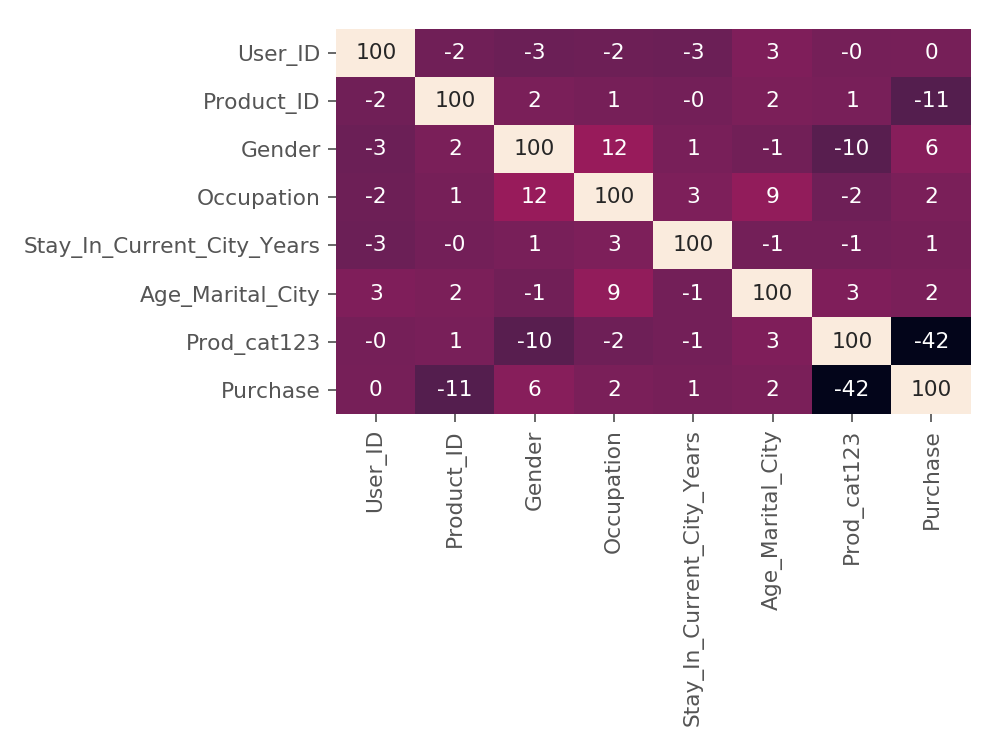

In [118]:
# add Prod cat123 and remove individual Prod cat
temp_cpy = df_cpy.loc[:,['Product_Category_1', \
           'Product_Category_2', \
           'Product_Category_3']].astype(str)
temp_cpy = temp_cpy.Product_Category_1 +'-'\
        +temp_cpy.Product_Category_2 +'-'\
        +temp_cpy.Product_Category_3
df_cpy.insert(len(df_cpy.columns)-1, 'Prod_cat123', temp_cpy)
df_cpy.drop(labels = ['Product_Category_1','Product_Category_2','Product_Category_3'],\
              inplace=True, axis = 1)
# use LabelEncoder to convert from string to numeric for correlation
Prod_cat123_encoder = LabelEncoder()
df_cpy.Prod_cat123 = Prod_cat123_encoder.fit_transform(df_cpy.Prod_cat123.values)

temp_Age_Marital_City_o = df_cpy.loc[:,['Age', \
           'Marital_Status', \
           'City_Category']].astype(str)
# merge content of columns
temp_Age_Marital_City_o = temp_Age_Marital_City_o.Age +'-'\
        +temp_Age_Marital_City_o.Marital_Status +'-'\
        +temp_Age_Marital_City_o.City_Category    
# assign name to new column
df_cpy.insert(len(df_cpy.columns)-2, 'Age_Marital_City', temp_Age_Marital_City_o)
df_cpy.drop(labels = ['Age','Marital_Status','City_Category'],\
              inplace=True, axis = 1)
# use LabelEncoder to convert from string to numeric for correlation
Age_Marital_City_encoder = LabelEncoder()
df_cpy.Age_Marital_City = Age_Marital_City_encoder.fit_transform(df_cpy.Age_Marital_City.values)

# show correlation
_ , axsn2 = plt.subplots()
sn.heatmap(df_cpy.corr()*100, ax=axsn2, square=False, fmt='.0f', annot=True, cbar=False)
# rotation is recognized for matplotlib version 2.1.X and above
axsn2.tick_params(axis = 'x',rotation = 90.0)
axsn2.tick_params(axis = 'y',rotation = 0.0)
plt.tight_layout()

<IPython.core.display.Javascript object>


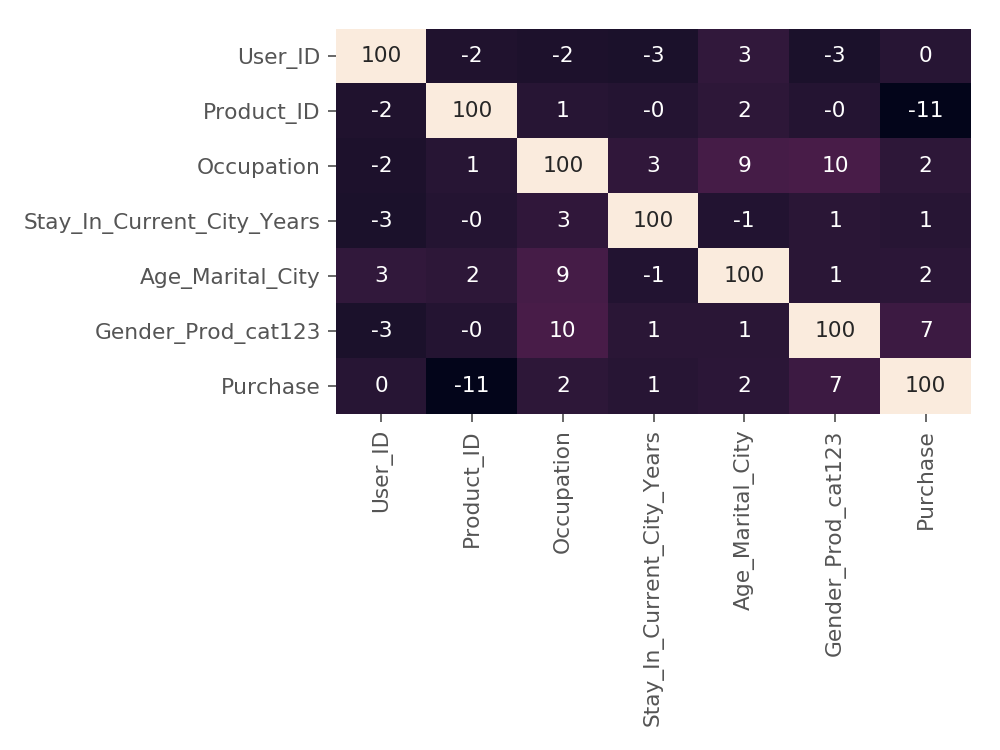

In [120]:
# Combine Prod cat123 and Gender
temp_cpy_G_cat = df_cpy.loc[:,['Gender', \
           'Prod_cat123']].astype(str)
temp_cpy_G_cat = temp_cpy_G_cat.Gender +'-'\
        +temp_cpy_G_cat.Prod_cat123
df_cpy.insert(len(df_cpy.columns)-1, 'Gender_Prod_cat123', temp_cpy_G_cat)
df_cpy.drop(labels = ['Gender','Prod_cat123'], inplace=True, axis = 1)
# use LabelEncoder to convert from string to numeric for correlation
Gender_Prod_cat123_encoder = LabelEncoder()
df_cpy.Gender_Prod_cat123 = Gender_Prod_cat123_encoder.fit_transform(df_cpy.Gender_Prod_cat123.values)

# show correlation
_ , axsn3 = plt.subplots()
sn.heatmap(df_cpy.corr()*100, ax=axsn3, square=False, fmt='.0f', annot=True, cbar=False)
# rotation is recognized for matplotlib version 2.1.X and above
axsn3.tick_params(axis = 'x',rotation = 90.0)
axsn3.tick_params(axis = 'y',rotation = 0.0)
plt.tight_layout()

# Polynomial model

To generate a non-linear model in order to improve our model accuracy, we can use scikit-learn PolynomialFeatures method.
It needs a dense matrix. Our feature matrix is sparse otherwise we will run out of memory. Thus it is not possible (at least on my machine) to generate polynomial features on all features.
It doesn't help to create polynomes on categorical features when we use one-hot encoding.<br><br>
Only years in current city is numeric (i.e. not categorical) I tried adding polynomes of years in current city. No improvement on metrics, it even decreased performance when degree > 3.

In [70]:
# from sklearn.preprocessing import PolynomialFeatures
# # object to compute 
# poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
# # compute polynomial features
# X_poly = poly.fit_transform(X)
# model.fit(X_poly, y)
# y_pred = model.predict(X_poly)
# print('{:.4f}'.format(r2_score(y, y_pred)))

# Ridge Regularization
Learning curves shows there is not much of a gap so overfitting is minimal. So there shouldn't be an improvement by adding regularization.

# Tree
Use tree instead of linear Regression

In [153]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor( min_samples_leaf = 6, random_state=29)
# , max_depth=237
tree_reg.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=6,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=29, splitter='best')

In [154]:
ytree_pred = tree_reg.predict(X)
from sklearn.metrics import mean_squared_error
print('MSE = {:.4f}'.format(mean_squared_error(y, ytree_pred)))
print('RMSE = {:.4f}'.format(np.sqrt(mean_squared_error(y, ytree_pred))))

MSE = 6699579.4449
RMSE = 2588.3546


#### Modules version

In [71]:
import sys
# sys.version_info for version formatted
print('Python version = {}'.format(sys.version.split('|', maxsplit=1)[0].strip()))
print('Pandas version = {}'.format(pd.__version__))
print('NumPy version = {}'.format(np.__version__))
print('Matplotlib version = {}'.format(sys.modules[plt.__package__].__version__))
skl = LabelEncoder.__module__.split('.', maxsplit=1)[0]
print('sci-kit learn version = {}'.format(sys.modules[skl].__version__))
sci = csr_matrix.__module__.split('.', maxsplit=1)[0]
print('SciPy version = {}'.format(sys.modules[sci].__version__))
print('Seaborn version = {}'.format(sn.__version__))

Python version = 3.5.4
Pandas version = 0.20.3
NumPy version = 1.13.1
Matplotlib version = 2.1.0
sci-kit learn version = 0.19.0
SciPy version = 0.19.1
Seaborn version = 0.8.0


## TODO
- check instances with highest error and lowest error (done, see above)
        Highest error analysis on Linear Regression is done
- check correlation after feature extraction (done, could combine Prod_cat123 with Gender and reevaluate but Gender does not improve our model...)
- correct for imbalance of instances based on Product ID (done, Rare Product Category123 and Rare Product ID do not yield worst predictions), about 2/3 of rare users (<16 instances) yields very high error.
        Add sample weights according to Users ID (?)
        Tried to remove instances of high error and retrain data => train accuracy up but test accuracy down!
- try decision tree
- try adding age as contineous feature (given as categorical)